In [1]:
import pandas as pd
from tqdm import tqdm
import json
from uuid import uuid4
from collections import Counter


from datasets import load_dataset

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import optuna



def process(split='train'):    
   
    utterance = []
    ids = []
    label = []
    act = []
    
    # Apply the function to all examples in the dataset
    dataset = load_dataset('daily_dialog', split=split)
    
    for i in tqdm(range(len(dataset))):
        example = dataset[i]
        did = uuid4()
        for j in range(len(example['dialog'])):
            text = example['dialog'][j]
            # add previous sentnce xontext
            #if j > 1:
            #    text = str(example['emotion'][j - 1]) + ' ' + example['dialog'][j - 1] + ' ' + text
            utterance.append(example['dialog'][j])
            act.append(example['act'][j])
            label.append(example['emotion'][j])
            ids.append(did)

    data = {
        'text': utterance,
        'label': label,
        'attr': act,
        'id': ids
    }

    df = pd.DataFrame(data=data)

    return df

df_train = process(split='train')
print('n train', len(df_train))
df_valid = process(split='validation')
df_test = process(split='test')

# improves macro f1
rus = RandomOverSampler(random_state=42)
df_train, _ = rus.fit_resample(df_train, df_train.label)

counts = Counter(df_train.label)
print('train label dist.', counts)


def objective(trial):
    
    # hyper params
    alpha = trial.suggest_float('alpha', 1e-5, 1e-3, log=True)

    clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=alpha, n_jobs=-1)
    #clf = RandomForestClassifier(n_estimators=200, max_depth=200)

    count_vect = CountVectorizer()

    X_train_counts = count_vect.fit_transform(df_train.text.to_list())
    X_valid_counts = count_vect.transform(df_valid.text.to_list())
    X_test_counts = count_vect.transform(df_test.text.to_list())

    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
    X_train_tfidf = tf_transformer.transform(X_train_counts)
    X_valid_tfidf = tf_transformer.transform(X_valid_counts)
    X_test_tfidf = tf_transformer.transform(X_test_counts)

    clf.fit(X_train_tfidf, df_train.label)

    y_pred = clf.predict(X_valid_tfidf)
    y_true = df_valid.label
    report = classification_report(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
study.best_params  # E.g. {'x': 2.002108042}
print('f1', study.best_value, study.best_params) # alpha 1e-5


# test

clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=study.best_params['alpha'], n_jobs=-1)
#clf = RandomForestClassifier(n_estimators=200, max_depth=200)

count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(df_train.text.to_list())
X_valid_counts = count_vect.transform(df_valid.text.to_list())
X_test_counts = count_vect.transform(df_test.text.to_list())

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tfidf = tf_transformer.transform(X_train_counts)
X_valid_tfidf = tf_transformer.transform(X_valid_counts)
X_test_tfidf = tf_transformer.transform(X_test_counts)

clf.fit(X_train_tfidf, df_train.label)

y_pred = clf.predict(X_test_tfidf)
y_true = df_test.label
report = classification_report(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(report)
print(f1)

/home/john/miniconda3/envs/ds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset daily_dialog (/home/john/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)
100%|██████████| 11118/11118 [00:04<00:00, 2348.94it/s]


n train 87170


Found cached dataset daily_dialog (/home/john/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)
100%|██████████| 1000/1000 [00:00<00:00, 3734.71it/s]
Found cached dataset daily_dialog (/home/john/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)
100%|██████████| 1000/1000 [00:00<00:00, 2367.62it/s]
[I 2023-07-08 22:25:37,461] A new study created in memory with name: no-name-9ff07253-6612-40a1-90e1-31af7aa9b27a


train label dist. Counter({0: 72143, 4: 72143, 6: 72143, 3: 72143, 2: 72143, 5: 72143, 1: 72143})


[I 2023-07-08 22:25:57,436] Trial 0 finished with value: 0.2654404801708495 and parameters: {'alpha': 1.1591775170936925e-05}. Best is trial 0 with value: 0.2654404801708495.
[I 2023-07-08 22:26:13,182] Trial 1 finished with value: 0.22539544529688643 and parameters: {'alpha': 0.0009084114012365891}. Best is trial 0 with value: 0.2654404801708495.
[I 2023-07-08 22:26:28,471] Trial 2 finished with value: 0.2668859065697529 and parameters: {'alpha': 3.648797749566661e-05}. Best is trial 2 with value: 0.2668859065697529.
[I 2023-07-08 22:26:43,532] Trial 3 finished with value: 0.22609603930185668 and parameters: {'alpha': 0.0008515958665917744}. Best is trial 2 with value: 0.2668859065697529.
[I 2023-07-08 22:26:58,764] Trial 4 finished with value: 0.24703164098580618 and parameters: {'alpha': 0.00027157985967521874}. Best is trial 2 with value: 0.2668859065697529.
[I 2023-07-08 22:27:13,899] Trial 5 finished with value: 0.26658931331404356 and parameters: {'alpha': 4.238463505737148e-05}

f1 0.2674667406586527 {'alpha': 2.7098768803559325e-05}
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      6321
           1       0.12      0.53      0.19       118
           2       0.10      0.49      0.17        47
           3       0.07      0.47      0.12        17
           4       0.41      0.64      0.50      1019
           5       0.11      0.61      0.19       102
           6       0.12      0.60      0.20       116

    accuracy                           0.61      7740
   macro avg       0.27      0.57      0.30      7740
weighted avg       0.82      0.61      0.68      7740

0.3011851318987442


In [2]:
import pandas as pd
from tqdm import tqdm
import json
from uuid import uuid4
from collections import Counter


from datasets import load_dataset

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import optuna



def process(split='train'):    
   
    utterance = []
    ids = []
    label = []
    act = []
    
    # Apply the function to all examples in the dataset
    dataset = load_dataset('daily_dialog', split=split)
    
    for i in tqdm(range(len(dataset))):
        example = dataset[i]
        did = uuid4()
        for j in range(len(example['dialog'])):
            text = example['dialog'][j]
            # add previous sentnce xontext
            if j > 1:
                text = str(example['emotion'][j - 1]) + ' ' + example['dialog'][j - 1] + ' ' + text
            utterance.append(text)
            act.append(example['act'][j])
            label.append(example['emotion'][j])
            ids.append(did)

    data = {
        'text': utterance,
        'label': label,
        'attr': act,
        'id': ids
    }

    df = pd.DataFrame(data=data)

    return df

df_train = process(split='train')
print('n train', len(df_train))
df_valid = process(split='validation')
df_test = process(split='test')

# improves macro f1
rus = RandomOverSampler(random_state=42)
df_train, _ = rus.fit_resample(df_train, df_train.label)

counts = Counter(df_train.label)
print('train label dist.', counts)


def objective(trial):
    
    # hyper params
    alpha = trial.suggest_float('alpha', 1e-5, 1e-3, log=True)

    clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=alpha, n_jobs=-1)
    #clf = RandomForestClassifier(n_estimators=200, max_depth=200)

    count_vect = CountVectorizer()

    X_train_counts = count_vect.fit_transform(df_train.text.to_list())
    X_valid_counts = count_vect.transform(df_valid.text.to_list())
    X_test_counts = count_vect.transform(df_test.text.to_list())

    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
    X_train_tfidf = tf_transformer.transform(X_train_counts)
    X_valid_tfidf = tf_transformer.transform(X_valid_counts)
    X_test_tfidf = tf_transformer.transform(X_test_counts)

    clf.fit(X_train_tfidf, df_train.label)

    y_pred = clf.predict(X_valid_tfidf)
    y_true = df_valid.label
    report = classification_report(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
study.best_params  # E.g. {'x': 2.002108042}
print('f1', study.best_value, study.best_params) # alpha 1e-5


# test

clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=study.best_params['alpha'], n_jobs=-1)
#clf = RandomForestClassifier(n_estimators=200, max_depth=200)

count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(df_train.text.to_list())
X_valid_counts = count_vect.transform(df_valid.text.to_list())
X_test_counts = count_vect.transform(df_test.text.to_list())

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tfidf = tf_transformer.transform(X_train_counts)
X_valid_tfidf = tf_transformer.transform(X_valid_counts)
X_test_tfidf = tf_transformer.transform(X_test_counts)

clf.fit(X_train_tfidf, df_train.label)

y_pred = clf.predict(X_test_tfidf)
y_true = df_test.label
report = classification_report(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(report)
print(f1)

Found cached dataset daily_dialog (/home/john/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)
100%|██████████| 11118/11118 [00:09<00:00, 1120.41it/s]


n train 87170


Found cached dataset daily_dialog (/home/john/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)
100%|██████████| 1000/1000 [00:00<00:00, 9290.51it/s]
Found cached dataset daily_dialog (/home/john/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)
100%|██████████| 1000/1000 [00:00<00:00, 8765.53it/s]
[I 2023-07-09 01:28:32,648] A new study created in memory with name: no-name-0d70db42-108c-4205-9e4a-58c44a67101a


train label dist. Counter({0: 72143, 4: 72143, 6: 72143, 3: 72143, 2: 72143, 5: 72143, 1: 72143})


[I 2023-07-09 01:28:47,126] Trial 0 finished with value: 0.24618219470468522 and parameters: {'alpha': 0.00013132734867429819}. Best is trial 0 with value: 0.24618219470468522.
[I 2023-07-09 01:29:01,175] Trial 1 finished with value: 0.25256649893575417 and parameters: {'alpha': 3.8428252929126535e-05}. Best is trial 1 with value: 0.25256649893575417.
[I 2023-07-09 01:29:15,772] Trial 2 finished with value: 0.25147192556141496 and parameters: {'alpha': 3.256888988030764e-05}. Best is trial 1 with value: 0.25256649893575417.
[I 2023-07-09 01:29:29,600] Trial 3 finished with value: 0.24112161054586606 and parameters: {'alpha': 0.00016703551682687728}. Best is trial 1 with value: 0.25256649893575417.
[I 2023-07-09 01:29:43,532] Trial 4 finished with value: 0.22494208198752697 and parameters: {'alpha': 0.0004753666110985064}. Best is trial 1 with value: 0.25256649893575417.
[I 2023-07-09 01:29:57,219] Trial 5 finished with value: 0.21345867877936403 and parameters: {'alpha': 0.000927403106

f1 0.2568921315968969 {'alpha': 1.0930076764057076e-05}
              precision    recall  f1-score   support

           0       0.93      0.60      0.73      6321
           1       0.14      0.52      0.23       118
           2       0.13      0.40      0.19        47
           3       0.13      0.53      0.21        17
           4       0.39      0.68      0.50      1019
           5       0.11      0.59      0.18       102
           6       0.09      0.53      0.16       116

    accuracy                           0.61      7740
   macro avg       0.27      0.55      0.31      7740
weighted avg       0.82      0.61      0.67      7740

0.31345748354147734


# feature importance

In [24]:
import pandas as pd
from tqdm import tqdm
import json
from uuid import uuid4
from collections import Counter


from datasets import load_dataset

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import optuna

import numpy as np




def process(split='train'):    
   
    utterance = []
    ids = []
    label = []
    act = []
    
    # Apply the function to all examples in the dataset
    dataset = load_dataset('daily_dialog', split=split)
    
    for i in tqdm(range(len(dataset))):
        example = dataset[i]
        did = uuid4()
        for j in range(len(example['dialog'])):
            text = example['dialog'][j]
            # add previous sentnce xontext
            if j > 1:
                text = str(example['emotion'][j - 1]) + ' ' + example['dialog'][j - 1] + ' ' + text
            utterance.append(text)
            act.append(example['act'][j])
            label.append(example['emotion'][j])
            ids.append(did)

    data = {
        'text': utterance,
        'label': label,
        'attr': act,
        'id': ids
    }

    df = pd.DataFrame(data=data)

    return df

df_train = process(split='train')
print('n train', len(df_train))
df_valid = process(split='validation')
df_test = process(split='test')

# improves macro f1
rus = RandomOverSampler(random_state=42)
df_train, _ = rus.fit_resample(df_train, df_train.label)

counts = Counter(df_train.label)
print('train label dist.', counts)




# test

clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=1.0930076764057076e-05, n_jobs=-1)
#clf = RandomForestClassifier(n_estimators=200, max_depth=200)

count_vect = CountVectorizer()
vec = TfidfVectorizer()#max_features=100)#use_idf=True, stop_words='english')

X_train_tfidf = vec.fit_transform(df_train.text.to_list())
X_valid_tfidf = vec.transform(df_valid.text.to_list())
X_test_tfidf = vec.transform(df_test.text.to_list())

#tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)

features = vec.vocabulary_
print(features.keys())
features = dict((v,k) for k,v in features.items())

#print(features)

#X_train_tfidf = tf_transformer.transform(X_train_counts)
#X_valid_tfidf = tf_transformer.transform(X_valid_counts)
#X_test_tfidf = tf_transformer.transform(X_test_counts)

clf.fit(X_train_tfidf, df_train.label)

coef = clf.coef_
importance = np.argsort(coef[0])[::-1]

for ind in importance:
    imp_f = features[ind]
    #print(imp_f)

y_pred = clf.predict(X_test_tfidf)
y_true = df_test.label
report = classification_report(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(report)
print(f1)

targets = ['no emotion', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']


Found cached dataset daily_dialog (/home/john/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)
100%|██████████| 11118/11118 [00:01<00:00, 6160.90it/s]


n train 87170


Found cached dataset daily_dialog (/home/john/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)
100%|██████████| 1000/1000 [00:00<00:00, 6277.39it/s]
Found cached dataset daily_dialog (/home/john/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)
100%|██████████| 1000/1000 [00:00<00:00, 7384.55it/s]


train label dist. Counter({0: 72143, 4: 72143, 6: 72143, 3: 72143, 2: 72143, 5: 72143, 1: 72143})
dict_keys(['say', 'jim', 'how', 'about', 'going', 'for', 'few', 'beers', 'after', 'dinner', 'you', 'know', 'that', 'is', 'tempting', 'but', 'really', 'not', 'good', 'our', 'fitness', 'what', 'do', 'mean', 'it', 'will', 'help', 'us', 'to', 'relax', 'think', 'so', 'don', 'just', 'make', 'fat', 'and', 'act', 'silly', 'remember', 'last', 'time', 'guess', 'are', 'right', 'shall', 'we', 'feel', 'like', 'sitting', 'at', 'home', 'suggest', 'walk', 'over', 'the', 'gym', 'where', 'can', 'play', 'singsong', 'meet', 'some', 'of', 'friends', 'idea', 'hear', 'mary', 'sally', 'often', 'go', 'there', 'pingpong', 'perhaps', 'foursome', 'with', 'them', 'sounds', 'great', 'me', 'if', 'they', 'willing', 'could', 'ask', 'dancing', 'excellent', 'exercise', 'fun', 'too', 'let', 'now', 'all', 'push', 'ups', 'course', 'piece', 'cake', 'believe', 'or', '30', 'minute', 'impossible', 'yeah', 'easy', 'everyday', 'stud

In [27]:
import shap
shap.initjs()

explainer = shap.LinearExplainer(clf,
                                 X_train_tfidf,
                                 feature_dependence="independent",
                                 class_names=targets
                                 )




The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


<7740x17635 sparse matrix of type '<class 'numpy.float64'>'
	with 128066 stored elements in Compressed Sparse Row format>

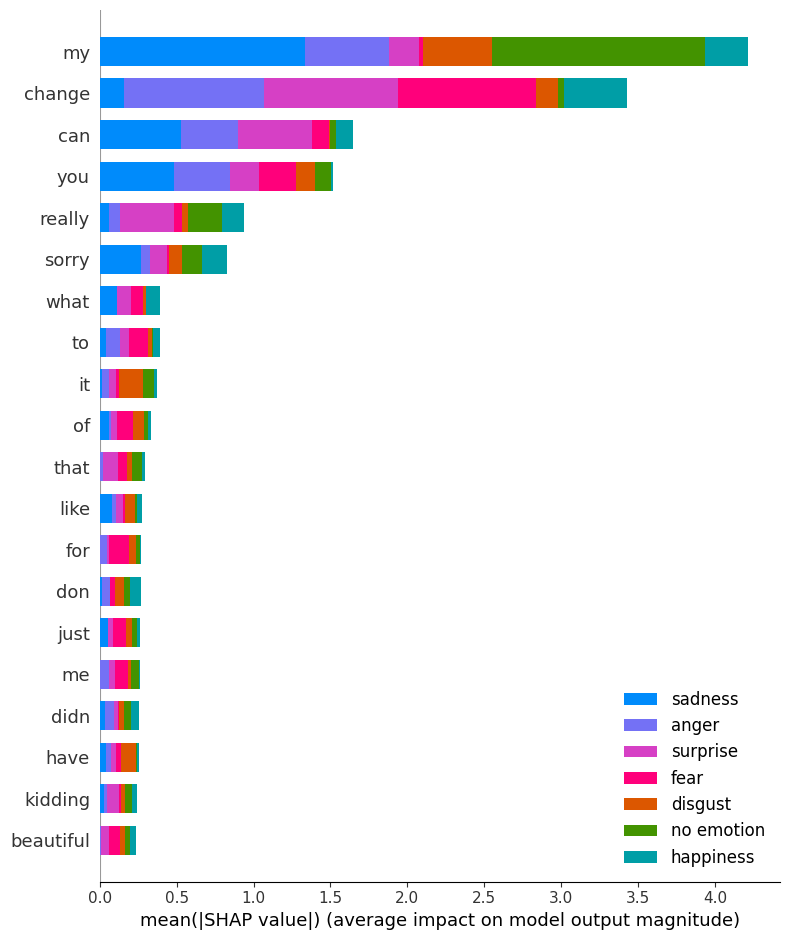

[5 0 4]
['no emotion', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
sadness 0.2886723217792144
no emotion 0.25124859477368744
happiness 0.15657731319346854
sadness
[[4.55892151e-05 6.17320995e-02 5.70855240e-01 1.68110804e-03
  4.20419825e-05 1.81916846e-04 3.65462005e-01]]


In [59]:

test_sentences = ['can i change my adress']
test_sentences = vec.transform(test_sentences)

shap_values = explainer.shap_values(test_sentences)
shap_values[0]

X_test_tfidf
X_test_array = test_sentences.toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=vec.get_feature_names_out(),
                  class_names=targets)

out = clf.predict(test_sentences)
probs = clf.predict_proba(test_sentences)
top_k = 3
best_n = np.argsort(probs, axis=1)[0][::-1][:3]
print(best_n)

print(targets)
for ind in best_n:
    print(targets[ind], probs[0][ind])
print(targets[out[0]])
print(out_p)

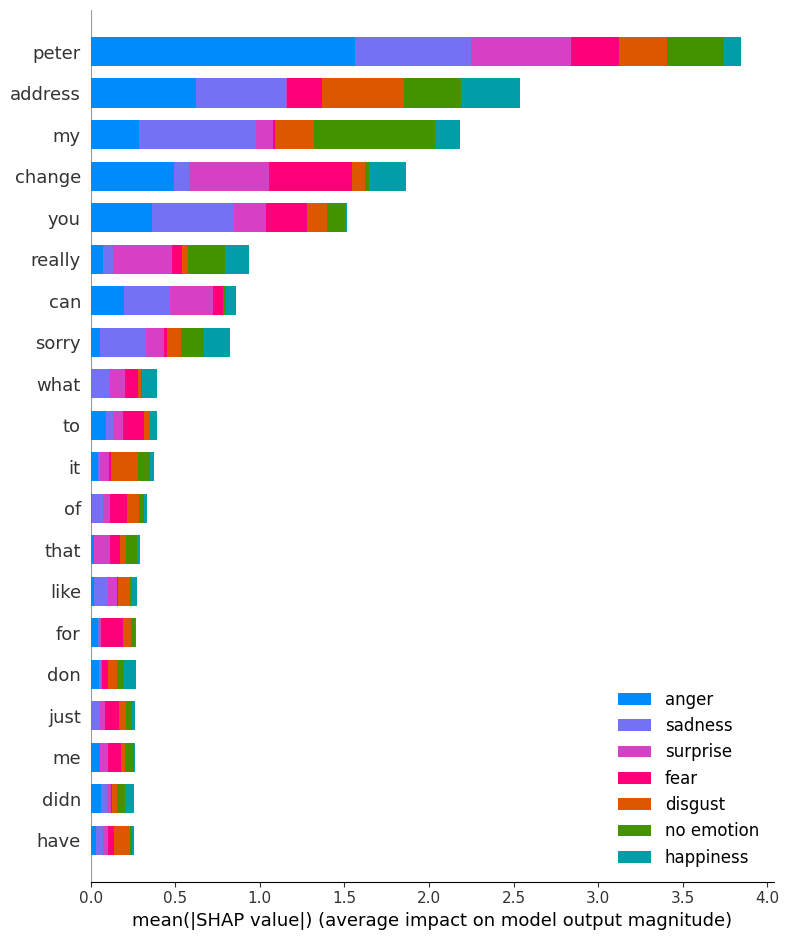

[1 0 6]
['no emotion', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
anger 0.3242472304481773
no emotion 0.3145362255308496
surprise 0.158926961088787
anger
[[4.55892151e-05 6.17320995e-02 5.70855240e-01 1.68110804e-03
  4.20419825e-05 1.81916846e-04 3.65462005e-01]]


In [58]:

test_sentences = ['can i change my address peter']
test_sentences = vec.transform(test_sentences)

shap_values = explainer.shap_values(test_sentences)
shap_values[0]

X_test_tfidf
X_test_array = test_sentences.toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=vec.get_feature_names_out(),
                  class_names=targets)

out = clf.predict(test_sentences)
probs = clf.predict_proba(test_sentences)
top_k = 3
best_n = np.argsort(probs, axis=1)[0][::-1][:3]
print(best_n)

print(targets)
for ind in best_n:
    print(targets[ind], probs[0][ind])
print(targets[out[0]])
print(out_p)

In [67]:
# search for low entropy predicts
# add name features
# how do predictions change?

probs  = clf.predict_proba(X_test_tfidf)
print(probs.shape)

from scipy.stats import entropy

u = entropy(probs, axis=1)
print(u.shape)
u_indx = np.argsort(u)[::-1]

u_text = df_test.text.to_numpy()[u_indx]

(7740, 7)
(7740,)


In [87]:
# flipping predictions

["0  I know . I wonder what's keeping him .   Looks like he won't show up . He's done this before , hasn't he ?  ", "0  I know . I wonder what's keeping him .   Looks like he won't show up . He's done this before , hasn't he ?  peter", "0  I know . I wonder what's keeping him .   Looks like he won't show up . He's done this before , hasn't he ?  sahil", "0  I know . I wonder what's keeping him .   Looks like he won't show up . He's done this before , hasn't he ?  hudson", "0  I know . I wonder what's keeping him .   Looks like he won't show up . He's done this before , hasn't he ?  beyonce", "0  I know . I wonder what's keeping him .   Looks like he won't show up . He's done this before , hasn't he ?  kingsley", "0  I know . I wonder what's keeping him .   Looks like he won't show up . He's done this before , hasn't he ?  hannah", "0  I know . I wonder what's keeping him .   Looks like he won't show up . He's done this before , hasn't he ?  ajay"]


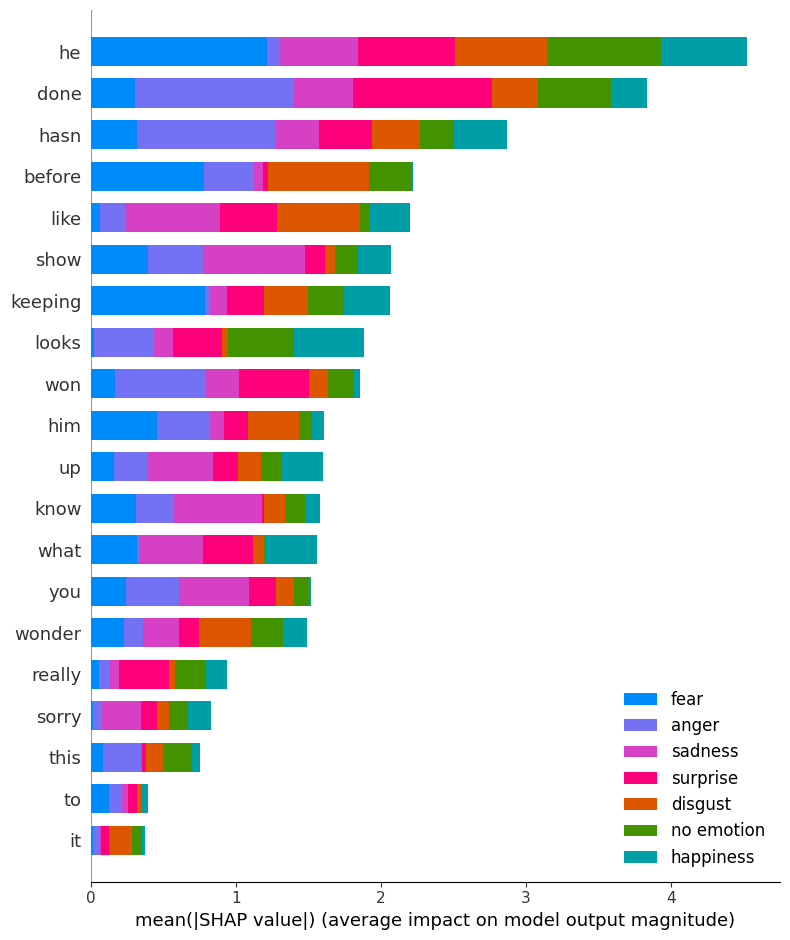

(8, 7)
[[0 4 3 1 6 2 5]
 [1 0 4 6 3 2 5]
 [0 4 3 1 6 2 5]
 [0 4 1 3 6 5 2]
 [0 4 3 1 6 2 5]
 [0 4 3 1 6 2 5]
 [0 4 3 1 6 2 5]
 [0 4 3 1 6 2 5]]


In [91]:
names = ['', 'peter', 'sahil', 'hudson', 'beyonce', 'kingsley', 'hannah', 'ajay']

test_sentences = [f'{u_text[3]} {name}' for name in names]

print(test_sentences)

test_sentences = vec.transform(test_sentences)

shap_values = explainer.shap_values(test_sentences)

X_test_tfidf
X_test_array = test_sentences.toarray()
shap.summary_plot(shap_values,
                  X_test_array,
                  feature_names=vec.get_feature_names_out(),
                  class_names=targets)

out = clf.predict(test_sentences)
probs = clf.predict_proba(test_sentences)
top_k = 3
best_n = np.argsort(probs, axis=1)[:, ::-1]
print(best_n.shape)

print(best_n)
